<a href="https://colab.research.google.com/github/igraves2/homework_1_repository/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Names (Enter your names below)
**Your Name and JHED:** Isabella Graves igraves2

**Partner's Name and JHED (If applicable):**  ...

# Lab 1: Heart Rate Estimation and Signal De-noising
By **Benjamín Béjar Haro** and edited by **Kwame Kutten**

In this lab we will address the problem of heart rate estimation from noisy observations. For a healthy individual, and under ideal conditions, this task might be easy to accomplish. However, different disorders together with different sources of error cause distortions to the signal rendering the estimation task more difficult. We will study how prior information about the signal and the interference can be exploited in order to improve the estimation task under less ideal conditions.

We will start detecting the QRS-complex assuming we have a template of the underlying waveform. Later, we will move to a more realistic scenario where we will be implementing a simplified version of the Pan-Tompkins algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029) and we will test it on real ECG data recordings.

### Objectives
By the end of this session you should be able to understand the main challenges in the estimation of EGC signals. How to work from modeling assupmtions in order to exploit your prior knowledge in the estimation task.

***

### Task 1. Signal generation and template matching
In this task we will implement a simple version of a QRS-complex detector by using template matching, thresholding and non-maximum suppresion on the
observed ECG signal. We will then use those detections to provide an estimate of the heart rate.

* **Task 1A: Signal Generation [15 points total] -** We are going to create a synthetic EGC signal that we will be using to test our detector algorithm. Each pulse should have a sampling rate of $f_s = 256\ Hz$. The goal of this task is to create a basic model for a ECG signal. You can think of the signal as the convolution of a canonical pulse shape $\varphi(t)$ with a stream of Dirac delta functions:

   $$x(t) = \sum_{k=1}^K a_k\, \varphi(t-t_k) = \varphi(t) \ast \sum_{k=1}^K a_k\, \delta(t-t_k),$$

   where $K$ is the number of pulses observed, $a_k$ represent the amplitudes of the different pulses and $t_k$ correspond to the locations of the pulses in time.
  * Generate a stream of $K = 10$ equally spaced pulses over a time span of $10\ s$ using the canonical pulse shape generated by the `ecg_wave()` function defined in the notebook and constant unit amplitudes $a_k=1$ [7 points].
  * Plot the generated signal over time [6 points]
  * Add x-axis and y-axis labels [2 points]


Text(0, 0.5, 'amplitude')

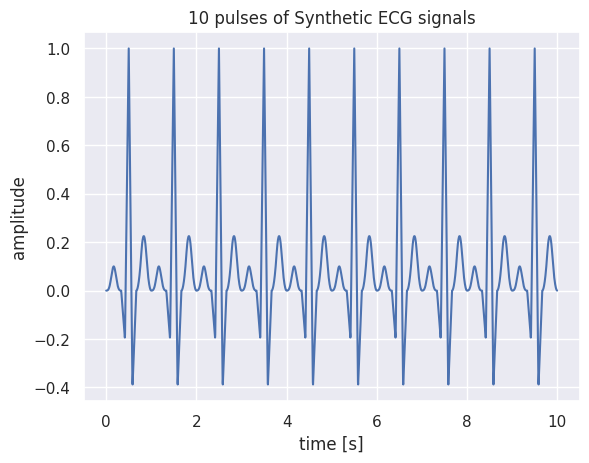

In [105]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.interpolate import BSpline

# inline plots
%matplotlib inline
sns.set()

# ============================================================================
# functions
# ============================================================================
def bspline(x,n):
    """
    Reimplementation since scipy.signal.bspline is no longer supported
    https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.signal.bspline.html
    """
    knots = np.arange(-(n+1)/2, (n+3)/2)
    res = BSpline.basis_element(knots)(x)
    res[(x<knots[0]) | (x > knots[-1])] = 0
    return res

def ecg_wave(x):
    """
    This function generates a single synthetic ECG template of unit length (support).
    For example, for a sampling frequency of f_s, use x = np.linspace(0,1, f_s, endpoint=False)
    """

    # compute signal (superposition of splines)
    return 0.3 * bspline(3*3*x-7.5,2)\
         + 0.15* bspline(3*4*x-2,3)\
         + bspline(3*2*2*x-6,1) - 0.2 *bspline(3*4*x-5,1) - 0.4 * bspline(3*4*x-7,1)


# ============================================================================
# Write Your code here
# ============================================================================
fs = 256  #frequency
K = 10
N = fs * K  #  Total # of samples
t = np.linspace(0, K, N, endpoint=False)  #given

# Initial template unit of ECG
temp = ecg_wave(np.linspace(0, 1, fs, endpoint=False))  # one impulse generated

ecg_signal = np.zeros(N) # This causes each signal to start at 0 initially

# creating a loop to get 10 pulses per every second
for k in range(10):
    start = k * fs
    end = start + fs
    if end <= N:
        ecg_signal[start:end] += temp  #adding on the other impulses based on the end of the template thus expanding the wave

# Plot of ECG signal
plt.figure()
plt.plot(t, ecg_signal, label="Synthetic ECG (10 real pulses)")
plt.title("10 pulses of Synthetic ECG signals")
plt.xlabel("time [s]")
plt.ylabel("amplitude")



* **Task 1B: Simulate Noise [5 points total]**
  * Generate a noisy version of the synthetic ECG signal generated by adding Gaussian noise with standard deviation $\sigma=0.5$ [2 points].
  * Plot the noisy observations [3 points].

Text(0, 0.5, 'amplitude')

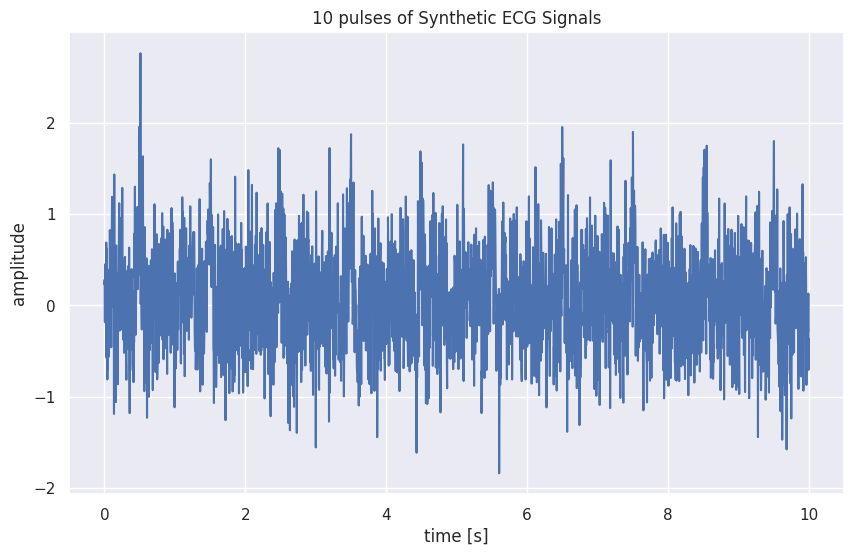

In [106]:
# ============================================================================
# Write Your code here
# ============================================================================
sigma=0.5 #standard deviation
noise=np.random.randn(N)*sigma
noisy_signal=ecg_signal+noise #noisy version of the synthetic ecg signal with the added gaussian noise with standard deviation
plt.figure(figsize=(10,6))
plt.plot(t, noisy_signal, label="Noisy ECG")
plt.title("10 pulses of Synthetic ECG Signals")
plt.xlabel("time [s]")
plt.ylabel("amplitude")

* **Task 1C: Find Peaks [10 points total] -** Implement a QRS-complex detector on the noisy signal you just generated. For that purpose we will use template matching, thresholding, and non-maximum suppression.
  * First you should implement template matching by correlating the noisy signal with a template ECG pulse using `np.correlate` [2 points]
  * Next normalize the signal to range $[0,1]$ using `noralize_range` [2 points]
  * Then plot the result [2 points]
  * Select a threshold value in $[0,1]$ that will separate QRS peeks from other peaks [1 point]
  * Next use `signal.find_peaks` with the `height` parameter set to the your chosen threshold to find locations of the QRS peaks [2 points]
  * Print the times of each peak in seconds [1 points]

QRS Peaks at threshold = 0.75:
[1.49 2.5  4.5  5.5  6.5  7.5  8.5  9.5 ]


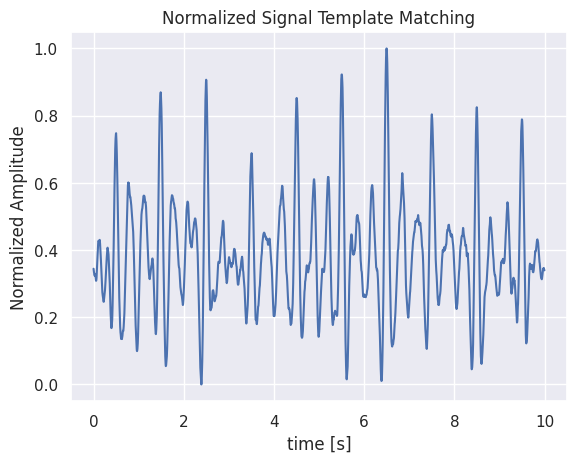

In [107]:
def normalize_range(x):
    """
    Normalizes the signal such that its minimum value is 0 and its maximum value is 1,
    provided the signal is not identically zero.
    """
    # check that there are non-zero elements
    if np.any(x):

        # subtract minimum
        minx = np.min(x)
        z = x - minx

        # divide by max value
        maxz = np.max(z)
        return z/maxz

    else:
        return x

# ============================================================================
# Write Your code here
# ============================================================================
sigma=0.5
noise=np.random.randn(N)*sigma
noisy_signal=ecg_signal+noise

template=ecg_wave(np.linspace(0, 1, fs, endpoint=False)) #inital pulse template
temp_match= np.correlate(noisy_signal, template, mode='same') #template matching
temp_match_normalized = normalize_range(temp_match) #normalized signal

plt.figure()
plt.plot(t, temp_match_normalized, label='Normalized Signal')
plt.title('Normalized Signal Template Matching')
plt.xlabel('time [s]')
plt.ylabel('Normalized Amplitude')

threshold=0.75 #assumption made for threshold value
peaks, p =signal.find_peaks(temp_match_normalized,0.75)
peak_times = peaks/fs

print("QRS Peaks at threshold = 0.75:")
print(np.round(peak_times, 2)) #Values of peak locations





* **Task 1D: RR Intervals [10 points total]**
  * Verify your results by ploting the original (synthetic) ECG signal overlaid with markers of peak locations. Keep in mind to compensate for any delay you might have introduced by filtering. [5 points]
  * Find the $R$ to $R$ interval sequence $r_n$ and its average value as $$ \bar R = \frac{1}{N}\sum_{n=0}^N r_n, $$ where $N$ is the number intervals between peaks.  Use this to display an estimate of the average heart beat rate in beats per minute (bpm) [5 points].


[1.49 2.5  4.5  5.5  6.5  7.5  8.5  9.5 ]
Average RR Interval: 1.1439732142857142
Estimated Heart Rate: 52.44878048780488


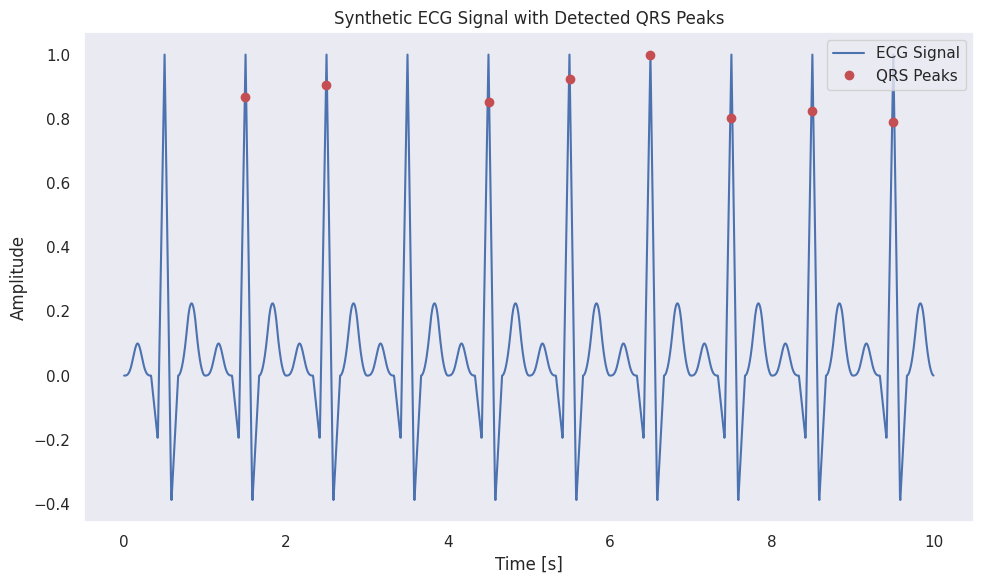

In [108]:
# ============================================================================
# Write your code here
# ============================================================================
rr_intervals = np.diff(peak_times)
average_rr = np.mean(rr_intervals)
heart_rate = 60 / average_rr

print(np.round(peak_times, 2))  # Values of peak locations
print("Average RR Interval:", average_rr)
print("Estimated Heart Rate:", heart_rate)

plt.figure(figsize=(10,6))
plt.plot(t, ecg_signal, label='ECG Signal') #gives graph from above part
plt.plot(peak_times, temp_match_normalized[peaks], 'ro', label='QRS Peaks') #gets the dots to be matched with the correct peak times
plt.title('Synthetic ECG Signal with Detected QRS Peaks')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Task 2. QRS complex detection via Pan-Tompkins algorithm
Now let us consider a more realistic scenario where we have a noisy ECG signal and the waveform of the QRS-complex is unknown. There are different sources of noise that can be present during an ECG acquisition. In addition to high-frequency thermal noise, it is also common to observe the presence of low-frequency interference coming from breathing.
When it comes to pathologies, different non-additive distortions might be present on the ECG signal
that alter the shape of the QRS-complex itself but for the purpose of this task we just assume a healthy  individual where signal distortion comes solely from the acquisition process. The procedure that we will employ in order to estimate the locations of the QRS-complex is based on the Pan-Tompkins algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029).

**Important Note 1:** You may need to **adjust the `myPath` variable below.**

**Important Note 2:** If you are using **Google Colab you must follow these steps**

1. Upload **ecg_mitnst.json** into your Google Drive.  If you placed it in a sub folder called **myFolder** the use `myPath = "myFolder/ecg_mitnst.json"`. Otherwise use `myPath = "ecg_mitnst.json"`
2. Run the folloing cell and follow displayed instructions

In [109]:
# ============================================================================
# Edit myPath variable below if necessary
# ============================================================================
import json

def read_data(path):
    try:
        # Executes if running in Google Colab
        from google.colab import drive
        drive.mount('gdrive/')
        path = 'gdrive/My Drive/'+path
    except:
        # Executes if running locally (e.g. Anaconda)
        pass

    with open(path,'r') as infile: data = json.load(infile)
    return data

# print data to see dictionary fields
myPath = "ecg_mitnst.json"
data = read_data(myPath)
print(data.keys())

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).
dict_keys(['fs', 'time', 'tk', 'voltage'])


**Task 2A: Effect of noise [10 points]:** The `data` dictionary contains four fields.  `fs` is the sampling frequency, `voltage` is the measured voltage in *mV* at corresponding `time` points and `t_k` contains the indices of the peaks. The signal corresponds to a sample ECG from the [MIT noise stress dataset](https://physionet.org/physiobank/database/nstdb/)
that has been downloaded from [physionet.org](https://physionet.org/physiobank/database/).
Note the presence of a strong low-frequency component.
  * Plot the voltage over time [5 points]
  * Add markers to indicate the given peaks [5 points]

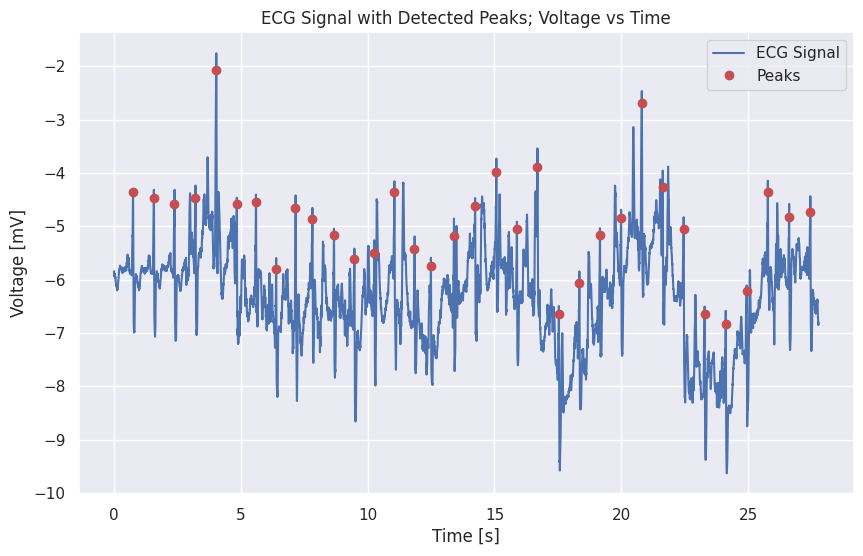

In [110]:
# ============================================================================
# Write your code here
# ============================================================================
voltage = np.array(data['voltage']) #used array to get the elements of voltage
time = np.array(data['time'])
t_k = np.array(data['tk']) #gives indices of the peaks
plt.figure(figsize=(10, 6))
plt.plot(time, voltage, label='ECG Signal')
plt.plot(time[t_k], voltage[t_k], 'ro', label='Peaks')
plt.title('ECG Signal with Detected Peaks; Voltage vs Time')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')
plt.legend()

#### **Pan-Tompkins Algorithm**
In order to deal with noise we will implement a simplified version of the Pan-Tompkins algorithm. For your convinence we have provided `boxFilter` and `triangleFilter` functions. Proceed as follows:

**Task 2B [10 points total]:** _Bandpass filtering:_ In this first step we want to eliminate as much as possible interference that is present in our acquired signal. In order to do that we can filter the signal and only leave the frequency range
that is of interest for our task (e.g. $5-15$ Hz as suggested in the original Pan-Tompkins paper) the bandpass filtering operation as the concatenation of a lowpass and a highpass filtering steps:

* _Highpass filtering:_ A highpass filter can be thought of as removing the lower frequency component of the signal. That means that we could use a lowpass filter to get a lowpass version of the original signal and then subtract the result from the original series.
   * We will use a lowpass filter of triangular shape and length $L$. Determine the length of the filter based on the required passband (i.e. the filter should attenuate significantly beyond $5$ Hz) or empirically by adjusting the value of $L$. Plot the original signal together with the lowpass filtered version. The latter one should describe the trend in the ECG recording [4 points].
   * Then plot the signal with the lowpass version subtracted to leave high-pass filtered signal [4 points].

* _Lowpass filtering:_ Use an averaging (box) filter to reduce high-frequency noise. Filter the signal with a filter of length $L=10$ taps [3 points].



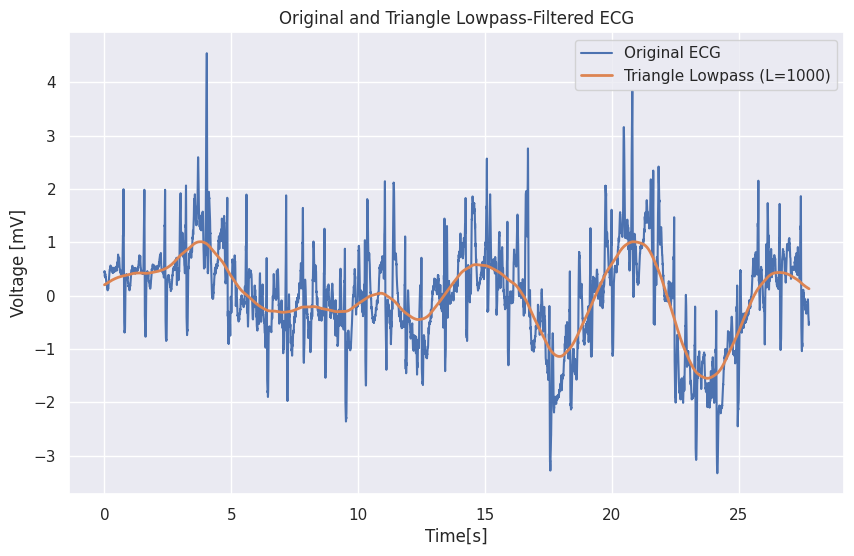

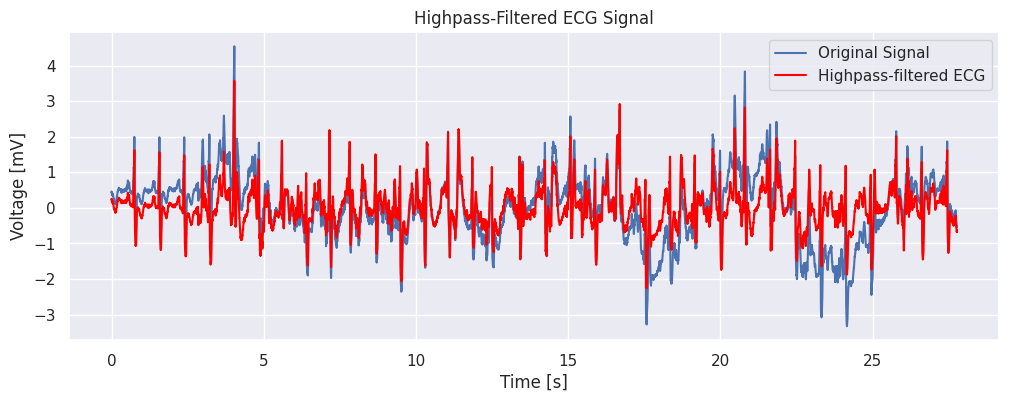

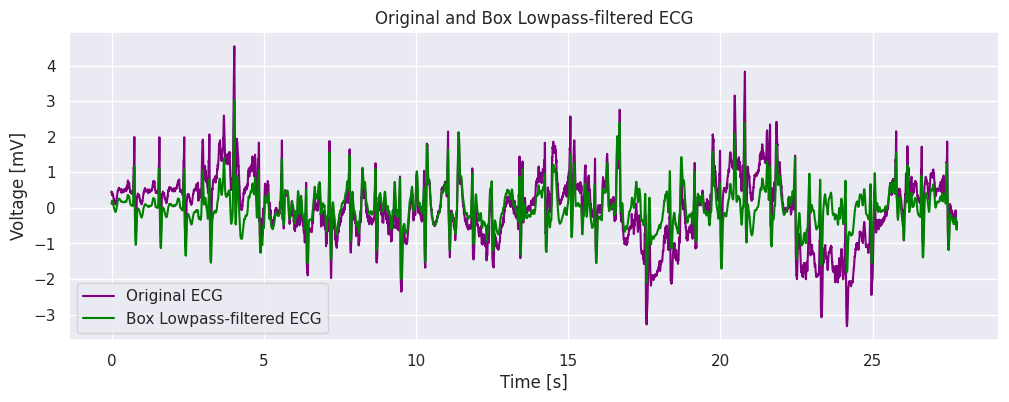

In [111]:
def boxFilter(L):
    """
    Genearte box filter of length L
    """
    h = np.ones(L)
    return h/np.sum(h)

def triangleFilter(L):
    """
    Generate triangle filter of length L
    """
    h = np.convolve(boxFilter(L//2), boxFilter(L//2))
    h = np.concatenate(([0],h))
    if L % 2: h = np.concatenate((h,[0]))
    return h/np.sum(h)

# ============================================================================
# Write your code here
# ============================================================================

t = data['time']
volt=data["voltage"]
volt-=np.mean(volt)
# Lowpass version of ECG
ecg_lowpassed_tri = np.convolve(volt, triangleFilter(1000), mode='same')

# Highpass version by subtracting the lowpass
ecg_highpassed = volt - ecg_lowpassed

# Plot original and lowpass-filtered signal
plt.figure(figsize=(10,6))
plt.plot(t, volt, label='Original ECG')
plt.plot(t, ecg_lowpassed_tri, label=f'Triangle Lowpass (L={L_hp})', linewidth=2)
plt.legend()
plt.title("Original and Triangle Lowpass-Filtered ECG")
plt.xlabel("Time[s]")
plt.ylabel("Voltage [mV]")
plt.grid(True)
plt.show()


# Plot highpass-filtered signal
plt.figure(figsize=(12, 4))
plt.plot(t, volt, label='Original Signal')
plt.plot(t, ecg_highpassed, color='red', label='Highpass-filtered ECG')
plt.legend()
plt.title("Highpass-Filtered ECG Signal")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [mV]")
plt.grid(True)
plt.show()


# Apply lowpass filter to the highpass-filtered signal
ecg_lowpassed_box = np.convolve(ecg_highpassed, boxFilter(10), mode='same')

# Plot low pass filter signal
plt.figure(figsize=(12, 4))
plt.plot(t, volt, label='Original ECG', color = 'purple')
plt.plot(t, ecg_lowpassed_box, label='Box Lowpass-filtered ECG', color='green')
plt.legend()
plt.title("Original and Box Lowpass-filtered ECG")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [mV]")
plt.grid(True)
plt.show()


**Task 2C [10 points total]:** _Differentiation_
 * Use a 1D numpy array to define the finite difference filter [3 points] $$d_n = \frac{1}{8}\big(\delta_{n-2} + 2\delta_{n-1} -2\delta_{n+1} - \delta_{n+2}\big)$$
 * Then differentiate the resulting signal in order to localize the region of steepest  slope  in  the  QRS-complex [2 points].  
 * Plot the result [5 points]

Text(0, 0.5, 'Voltage [mV]')

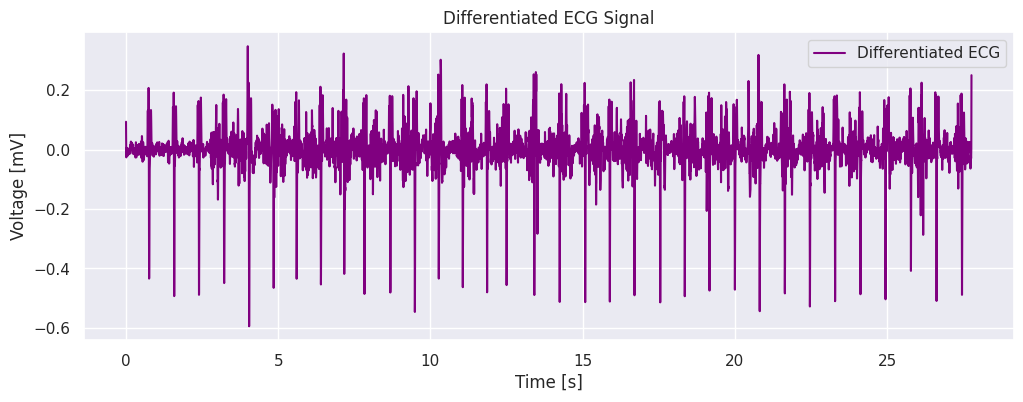

In [116]:
# ============================================================================
# Write your code here
# ============================================================================
d_n=np.array([1/8, 2/8, 0, -2/8, -1/8])
differentiated_signal=np.convolve(ecg_highpassed, d_n, mode='same') #convolution gives differentiated signal
plt.figure(figsize=(12, 4))
plt.plot(t, differentiated_signal, label='Differentiated ECG', color='purple')
plt.legend()
plt.title("Differentiated ECG Signal")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [mV]")

**Task 2D [10 points total]:** _Signal squaring_
 * Square the signal after differentiation [5 points]
 * Plot the result [5 points]

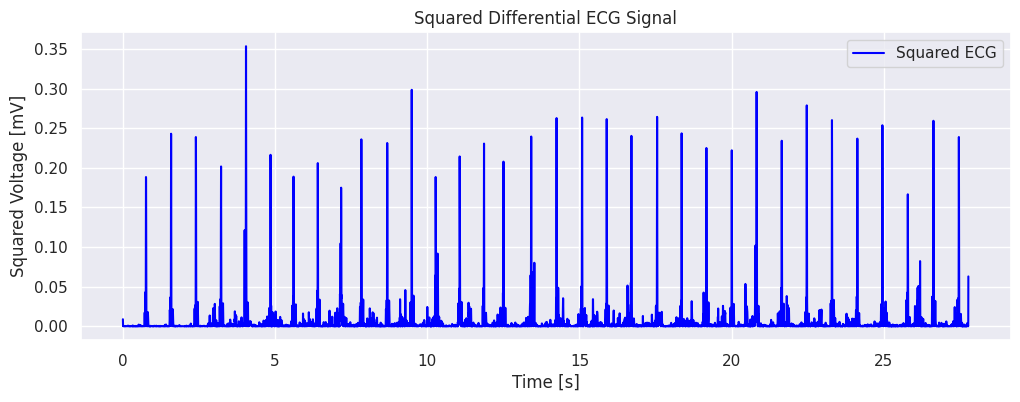

In [113]:
# ============================================================================
# Write your code here
# ============================================================================
squared_signal=differentiated_signal** #squaring signal from before
plt.figure(figsize=(12, 4))
plt.plot(t, squared_signal, label='Squared ECG', color='blue')
plt.legend()
plt.title("Squared Differential ECG Signal")
plt.xlabel("Time [s]")
plt.ylabel("Squared Voltage [mV]")
plt.grid(True)
plt.show()

**Task 2E [10 points total]:** _Integration_
 * Integrate the resulting signal from the squaring operation with a box window of length $L=50$ [5 points]
 * Plot the resulting signal [5 points]

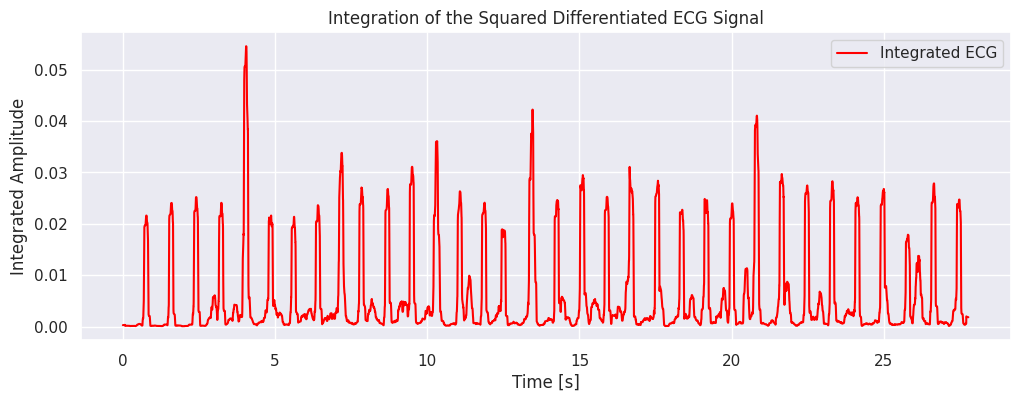

In [114]:
# ============================================================================
# Write your code here
# ============================================================================
integrated_signal=np.convolve(squared_signal, boxFilter(50), mode='same') #convolution gives integrated signal
plt.figure(figsize=(12, 4))
plt.plot(t, integrated_signal, label='Integrated ECG', color='red')
plt.legend()
plt.title("Integration of the Squared Differentiated ECG Signal")
plt.xlabel("Time [s]")
plt.ylabel("Integrated Amplitude")
plt.grid(True)
plt.show()

**Task 2F [10 points total]:** _Peak detection_
 * Use `signal.find_peaks` with an appropriate `height` threshold to estimate locations of QRS peaks [2 points]
 * Replot the previous plot with markers at these peak locations [4 points].
 * In a differnt plot display the heart beat rate over time estimated from the **R** to **R** intervals [4 points]

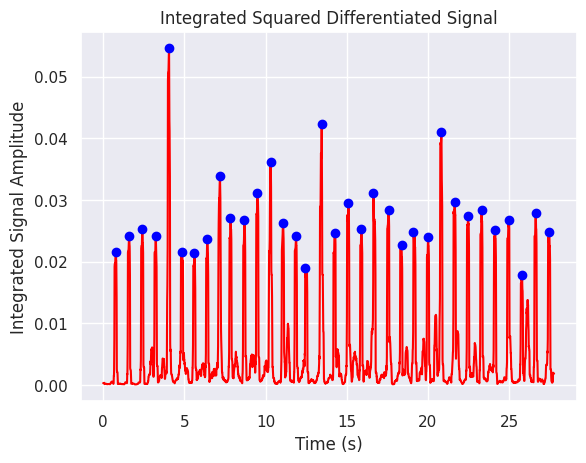

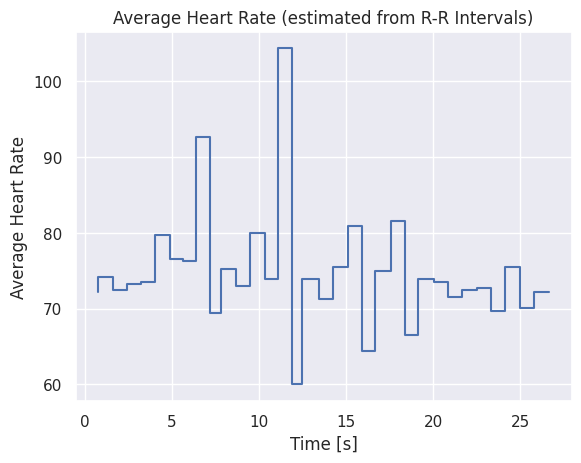

In [115]:
# ============================================================================
# Write your code here
# ============================================================================

time = data['time']
threshold = 0.0075
peaks, p = signal.find_peaks(integrated_signal, height=threshold, distance=200) #using this to estimate locations of QRS peaks
plt.plot(time, integrated_signal, label='Integrated ECG', color='red')

plt.plot([time[i] for i in peaks], integrated_signal[peaks], 'o', color = 'blue');

plt.xlabel('Time (s)')
plt.ylabel('Integrated Signal Amplitude')
plt.title('Integrated Squared Differentiated Signal')
plt.show()



time_peaks = []
for i in peaks:
  time_peaks.append(time[i])

rr_interval = np.diff(time_peaks)
heart_rate = 60 / rr_interval

plt.step(time_peaks[:-1], heart_rate)
plt.xlabel('Time [s]')
plt.ylabel('Average Heart Rate')
plt.title('Average Heart Rate (estimated from R-R Intervals)')
plt.show()